### Importing Packages

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery, storage

# from utils import *
from ten_chart import *
import math
import talib

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from termcolor import colored as cl 

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 10)


from datetime import datetime, timedelta, date
import datetime

# Using graph_objects
import plotly.graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

### Extracting DATA

In [2]:
# present day
dt='20221206'

query = f"""

    WITH content_t AS (
        SELECT 
            natid,
            title,
            pub_date,
            pub_time,
            pub_date_time

        FROM (
            SELECT DISTINCT
            EXTRACT(DATE FROM DATETIME(date, "America/New_York")) as pub_date,
            EXTRACT(TIME from DATETIME(date, "America/New_York")) as pub_time,
            DATETIME(date, "America/New_York") as pub_date_time,
            LOWER(NaturalId) AS natid,
            title,
            RANK() OVER (PARTITION BY naturalid ORDER BY timestamp DESC) AS mostrecent
        FROM
            `api-project-901373404215.Content.content`
        WHERE
            Visible is true
                AND type in (
                'blog',
                'blogslide',
                'magazine'
            )
        )
        WHERE 
        mostrecent = 1            ),

    ga_rt_sess AS (
            SELECT
                hour,
                minute,
                date as ga_date,
                fullvisitorid,
                COUNT(DISTINCT 
                  CONCAT(
                      CAST(fullvisitorid AS string),
                      CAST(visitid AS string),
                      CAST(hits.page.pagePath AS string),
                      CAST(visitStartTime AS string),
                      CAST(visitNumber AS string),
                      CAST(hits.hitNumber AS string))
                ) AS pageviews,
                CAST(MAX((IF(CDS.index=24,CDS.value,NULL))) AS STRING) AS natid,
                CAST(MAX((IF(CDS.index=107,CDS.value,NULL))) AS STRING) AS piano_id
            FROM
                `api-project-901373404215.206396628.ga_realtime_sessions_{dt}`,
                UNNEST(hits) AS hits,
                UNNEST(hits.customdimensions) AS CDS
            WHERE
                hits.type = 'PAGE'
            GROUP BY
                fullvisitorid, 
                hits.page.pagePath,
                trafficSource.source,
                trafficSource.medium,
                trafficSource.campaign,
                hits.hour,
                hits.minute,
                ga_date
        )

        SELECT 
            natid,
            title,
            pub_date,
            pub_time,
            pub_date_time,
            SUM(pageviews) AS pageviews,
            hour,
            minute,
            ga_date

        FROM (
            SELECT
                ga_rt_sess.natid,
                title,
                ga_rt_sess.piano_id AS ga_piano_id,
                SUM(pageviews) AS pageviews,
                hour,
                minute,
                ga_date,
                pub_date,
                pub_time,
                pub_date_time
            FROM 
                ga_rt_sess 
            INNER JOIN
                content_t
            ON
                LOWER(ga_rt_sess.natid) = LOWER(content_t.natid)

            GROUP BY
                natid,
                title,
                ga_rt_sess.piano_id,
                pub_date,
                pub_time,
                pub_date_time,
                hour,
                minute,
                ga_date
        )  
                
        GROUP BY
            natid,
            title,
            pub_date,
            pub_time,
            pub_date_time,
            hour,
            minute,
            ga_date
        """

In [3]:
#Data Fetching
bq_client = bigquery.Client()
df = bq_client.query(query).to_dataframe()

# Sort by minute within hour
df = df.sort_values(by=['hour', 'minute'], ascending=True)
df['natid']=df['natid'].apply(lambda x: x.lower())

print(df.shape)
df.head()

(676354, 9)


,natid,title,pub_date,pub_time,pub_date_time,pageviews,hour,minute,ga_date
1,blogandpostid/blog/post/7141-609e7f7fc89144000...,Don’t Self-Publish A Book Before Answering The...,2021-05-17,08:20:00,2021-05-17 08:20:00,1,0,0,20221206
13,blogandpostid/blog/post/4983-6000c5d6735300000...,"The Best Workout Leggings To Wear To The Gym, ...",2022-09-08,14:25:50,2022-09-08 14:25:50,2,0,0,20221206
16,blogandpostid/blog/post/3306-638a391a982bbe000...,Key Indicators Imply A 2023 Recession Yet The ...,2022-12-02,13:21:50,2022-12-02 13:21:50,1,0,0,20221206
17,blogandpostid/blog/post/5417-5ed90e156110a5000...,"As Dividends Get Cut, ETF Offers Steady 7% Ann...",2020-06-04,11:33:19,2020-06-04 11:33:19,1,0,0,20221206
25,blogandpostid/blog/post/7456-5dbf5eabe790b7000...,How To Make Workplaces More Welcoming For Empl...,2019-11-04,11:13:07,2019-11-04 11:13:07,2,0,0,20221206


In [4]:
#filtering only selected features
df_fin=df[['natid', 'title', 'pub_date', 'pub_time','pub_date_time', 'pageviews', 'hour', 'minute','ga_date']]


### Creating Features

In [5]:
# Create a time column from the hour and minute
df_fin['time'] = pd.to_datetime(df_fin['hour'].astype(str) + ':' + df_fin['minute'].astype(str), format='%H:%M').dt.time

# Create a day_time column from the ga date and time
df_fin['day_time']=pd.to_datetime(df_fin['ga_date'].apply(str)+ ' ' + df_fin['time'].apply(str))

#changing data type to datetime
df_fin['ga_date'] = pd.to_datetime(df_fin['ga_date'], errors='coerce')

df_fin['pub_date'] = pd.to_datetime(df_fin['pub_date'], errors='coerce')

In [6]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676354 entries, 1 to 177859
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   natid          676354 non-null  object        
 1   title          676354 non-null  object        
 2   pub_date       676354 non-null  datetime64[ns]
 3   pub_time       676354 non-null  object        
 4   pub_date_time  676354 non-null  datetime64[ns]
 5   pageviews      676354 non-null  int64         
 6   hour           676354 non-null  int64         
 7   minute         676354 non-null  int64         
 8   ga_date        676354 non-null  datetime64[ns]
 9   time           676354 non-null  object        
 10  day_time       676354 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(3), object(4)
memory usage: 61.9+ MB


In [7]:
df_fin.isna().sum()

natid            0
title            0
pub_date         0
pub_time         0
pub_date_time    0
pageviews        0
hour             0
minute           0
ga_date          0
time             0
day_time         0
dtype: int64

In [8]:
print('Number of Unique Articles: ', len(df_fin.natid.unique()))

Number of Unique Articles:  118646


In [9]:
df_fin.head()

,natid,title,pub_date,pub_time,pub_date_time,pageviews,hour,minute,ga_date,time,day_time
1,blogandpostid/blog/post/7141-609e7f7fc89144000...,Don’t Self-Publish A Book Before Answering The...,2021-05-17,08:20:00,2021-05-17 08:20:00,1,0,0,2022-12-06,00:00:00,2022-12-06
13,blogandpostid/blog/post/4983-6000c5d6735300000...,"The Best Workout Leggings To Wear To The Gym, ...",2022-09-08,14:25:50,2022-09-08 14:25:50,2,0,0,2022-12-06,00:00:00,2022-12-06
16,blogandpostid/blog/post/3306-638a391a982bbe000...,Key Indicators Imply A 2023 Recession Yet The ...,2022-12-02,13:21:50,2022-12-02 13:21:50,1,0,0,2022-12-06,00:00:00,2022-12-06
17,blogandpostid/blog/post/5417-5ed90e156110a5000...,"As Dividends Get Cut, ETF Offers Steady 7% Ann...",2020-06-04,11:33:19,2020-06-04 11:33:19,1,0,0,2022-12-06,00:00:00,2022-12-06
25,blogandpostid/blog/post/7456-5dbf5eabe790b7000...,How To Make Workplaces More Welcoming For Empl...,2019-11-04,11:13:07,2019-11-04 11:13:07,2,0,0,2022-12-06,00:00:00,2022-12-06


### Filtering Articles


#### All Articles - leaving current date

In [10]:
date='2022-12-06'
x=5
y=9
frm=datetime.time(x, 0, 0)
to=datetime.time(y, 0, 0)

In [11]:
#filtering data for 4 hours
df_fil_day=df_fin[(df_fin.time>= frm) & (df_fin.time<= to)]


In [12]:
print(df_fil_day.time.min())
print(df_fil_day.time.max())

05:00:00
09:00:00


In [13]:

total_pv=df_fil_day.groupby('natid')['pageviews'].agg('sum').reset_index()
total_pv=total_pv.sort_values(by=['pageviews'], ascending=False)

total_pv.head()

,natid,pageviews
44591,blogandpostid/blog/post/51339-638e97f8ffde4c00...,18383
35633,blogandpostid/blog/post/4970-63405a74ca7f6d000...,16189
11235,blogandpostid/blog/post/2282-638b8e5fedcf34000...,13626
3699,blogandpostid/blog/post/1360-638bfefcf4926f000...,12926
35640,blogandpostid/blog/post/4970-6365453c6653f8000...,10790


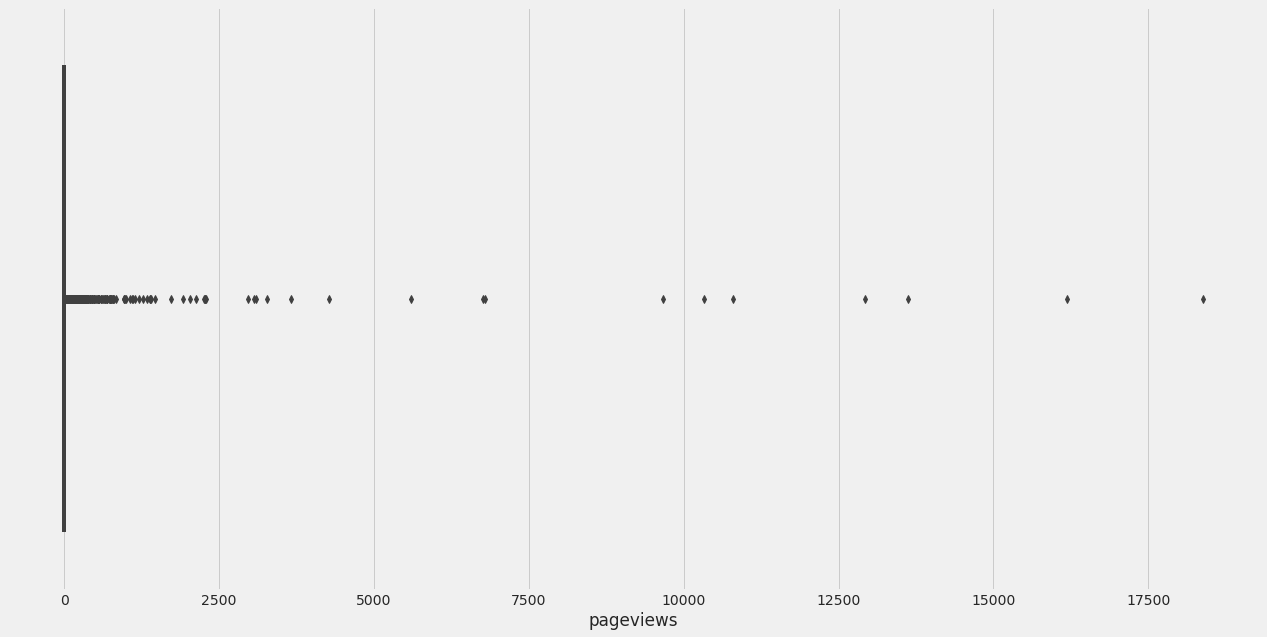

In [14]:
#box plot of total pageviews for each article
sns.boxplot(x=total_pv.pageviews);

In [15]:
for i in np.arange(0.1,1,0.1):
    print(round((i*100),0),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

10.0 th Percentile of Total Pageviews:  1.0
20.0 th Percentile of Total Pageviews:  1.0
30.0 th Percentile of Total Pageviews:  1.0
40.0 th Percentile of Total Pageviews:  1.0
50.0 th Percentile of Total Pageviews:  1.0
60.0 th Percentile of Total Pageviews:  2.0
70.0 th Percentile of Total Pageviews:  2.0
80.0 th Percentile of Total Pageviews:  3.0
90.0 th Percentile of Total Pageviews:  6.0


In [16]:
for i in np.arange(0.9,1,0.01):
    print(round((i*100),0),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

90.0 th Percentile of Total Pageviews:  6.0
91.0 th Percentile of Total Pageviews:  7.0
92.0 th Percentile of Total Pageviews:  8.0
93.0 th Percentile of Total Pageviews:  9.0
94.0 th Percentile of Total Pageviews:  10.0
95.0 th Percentile of Total Pageviews:  12.0
96.0 th Percentile of Total Pageviews:  15.0
97.0 th Percentile of Total Pageviews:  20.0
98.0 th Percentile of Total Pageviews:  29.0
99.0 th Percentile of Total Pageviews:  56.0


In [17]:
for i in np.arange(0.99,1,0.001):
    print(round((i*100),2),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

99.0 th Percentile of Total Pageviews:  56.0
99.1 th Percentile of Total Pageviews:  62.0
99.2 th Percentile of Total Pageviews:  69.0
99.3 th Percentile of Total Pageviews:  77.8530000000028
99.4 th Percentile of Total Pageviews:  92.0
99.5 th Percentile of Total Pageviews:  112.0
99.6 th Percentile of Total Pageviews:  143.91599999999744
99.7 th Percentile of Total Pageviews:  189.93699999999808
99.8 th Percentile of Total Pageviews:  272.87399999999616
99.9 th Percentile of Total Pageviews:  555.9160000000265
100.0 th Percentile of Total Pageviews:  18383.0


In [19]:
for i in np.arange(0.999,1,0.0001):
    print(round((i*100),3),"th Percentile of Total Pageviews: ",total_pv.pageviews.quantile(i))

99.9 th Percentile of Total Pageviews:  555.9160000000265
99.91 th Percentile of Total Pageviews:  631.8708000000042
99.92 th Percentile of Total Pageviews:  696.2488000000085
99.93 th Percentile of Total Pageviews:  763.1970999999612
99.94 th Percentile of Total Pageviews:  961.499199999962
99.95 th Percentile of Total Pageviews:  1123.1954999996742
99.96 th Percentile of Total Pageviews:  1404.0403999999398
99.97 th Percentile of Total Pageviews:  2260.061400000108
99.98 th Percentile of Total Pageviews:  3169.0145999983433
99.99 th Percentile of Total Pageviews:  8798.066699976822
100.0 th Percentile of Total Pageviews:  18382.999999984037


In [20]:
#filtering articles with top 0.001th percentile
data_filter =total_pv[total_pv['pageviews'] >= total_pv.pageviews.quantile(0.999)]
natids_filter=data_filter.natid.unique().tolist()
print(len(natids_filter))


64


In [21]:
df_fil=df_fil_day[df_fil_day['natid'].isin (natids_filter)]
print(df_fil.shape)
print('Number of Unique Articles: ', len(df_fil.natid.unique()))

(14515, 11)
Number of Unique Articles:  64


In [22]:
#List of natural Ids of articles
natids=df_fil.natid.unique().tolist()
len(natids)

64

In [23]:
#helper function to create data 
def create_dataframe(natural_ids,df,date,time_from,time_to):
    
    #create dummy dataframe
    res = pd.DataFrame()
    
    for natid in natural_ids:
        #creating a new data frame tm - it has every minute of a day
        tm = (pd.DataFrame(natid,columns=['natid'],
                          index=pd.date_range(f'{date}'+'T00:00:00', f'{date}'+'T23:59:59',freq='1T'))
              .between_time(f'{time_from}',f'{time_to}')
              .reset_index()
        )
        tm.columns=['day_time','natid']
        tm['day_time']=pd.to_datetime(tm['day_time'])
        
        #filter data for each article
        test=df[df['natid']==natid]
        
        #time difference
        time_diff_before=(test['day_time'].tolist()[0])-timedelta(minutes=15)     
        
        time_diff_after=(test['day_time'].tolist()[-1])+timedelta(minutes=5)  
        
        # Merge with the test df
        #first data point always zero, we can change it
     
        test = pd.merge(
            test,
            tm,
            on=['day_time','natid'],
            how='right'
        )
        
        #rolling sum
        #creating cumulative pageviews
        test['pageviews'] =test['pageviews'].fillna(0)
        test['rolling_pv'] =test['pageviews'].rolling(15).sum() # we can change "n"
        test['rolling_pv'] =test['rolling_pv'].fillna(0)
       
        test['return_rolling_pv']=test['rolling_pv'].pct_change(1)
        test['return_rolling_pv']=test['return_rolling_pv'].fillna(0)
        test['return_rolling_pv'] = np.where(test['return_rolling_pv'] == math.inf,
                                             test['rolling_pv'], test['return_rolling_pv'])
        

        #filter data 
        test=test[test['day_time']>time_diff_before]
        
        test=test[test['day_time']<time_diff_after]
        
        res=res.append(test)
        
    return res

In [24]:
#taking data for time between 6am to 10am
data=create_dataframe(natids,df_fil,date,str(frm),str(to))
data.shape

(15342, 13)

### Best Perfroming Articles:

In [25]:
#helper function to calculate sharpe ratio
def sharpe_ratio(df):
    return df['return_rolling_pv'].mean() /df['return_rolling_pv'].std()

In [26]:
#helper function to calculate coefficient of variation
def coefficient_variation(df):
    return df['rolling_pv'].mean() /df['rolling_pv'].std()

In [27]:
#descriptive stats
stat=data.groupby('natid')['rolling_pv'].describe().reset_index()
#skew
skew=data.groupby('natid').agg(skew = pd.NamedAgg(column="rolling_pv", aggfunc="skew"))
#kurtois
kurt=data.groupby('natid').agg( kurt =  pd.NamedAgg(column="rolling_pv", aggfunc=pd.DataFrame.kurt))
#sharpe ratio
sharpe_ratio = data.groupby('natid').apply(sharpe_ratio)
sharpe_ratio=pd.DataFrame({'natid':sharpe_ratio.index, 'sharpe_ratio':sharpe_ratio.values})

#coefficient of variation
cv = data.groupby('natid').apply(coefficient_variation)
cv=pd.DataFrame({'natid':cv.index, 'cv':cv.values})

In [28]:
#merging all data
stat = pd.merge(stat,skew,on=['natid'],how='right')
stat = pd.merge(stat,kurt,on=['natid'],how='right')
stat = pd.merge(stat,sharpe_ratio,on=['natid'],how='right')
stat = pd.merge(stat,cv,on=['natid'],how='right')


In [29]:
stat = stat.sort_values(by=['max','cv','sharpe_ratio'], ascending=False)
stat.head()

,natid,count,mean,std,min,25%,50%,75%,max,skew,kurt,sharpe_ratio,cv
21,blogandpostid/blog/post/4970-63405a74ca7f6d000...,241.0,936.767635,404.328615,0.0,618.0,977.0,1178.0,1717.0,-0.220705,0.011224,0.064384,2.316847
42,blogandpostid/blog/post/51339-638e97f8ffde4c00...,241.0,1082.323651,388.669422,0.0,877.0,1022.0,1450.0,1697.0,-0.835274,1.265873,0.064478,2.784689
30,blogandpostid/blog/post/50356-638e4d0140013d00...,241.0,567.497925,349.726764,0.0,232.0,540.0,815.0,1307.0,0.245232,-0.858236,0.064415,1.622689
10,blogandpostid/blog/post/2282-638b8e5fedcf34000...,241.0,805.170124,333.004918,0.0,526.0,827.0,1127.0,1234.0,-0.649431,-0.277790,0.064583,2.417893
22,blogandpostid/blog/post/4970-6365453c6653f8000...,241.0,623.800830,258.871626,0.0,476.0,642.0,802.0,1122.0,-0.345072,0.246220,0.064382,2.409692


## Momentum Indicators

### Combined method: Bollinger Bands + RSI



In [30]:
#sma
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

In [31]:
#Bollinger Bands
def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 1.5
    return upper_bb

In [32]:
def momentum(data,natids):
    #create dummy dataframe
    res = pd.DataFrame()
    
    for natid in natids:
        df=data[data['natid']==natid]
        
        #creating SMA
        df['sma'] = sma(df['rolling_pv'], 7)
        df['sma'] = df['sma'].fillna(0)
        
        #creating upper and lower bands
        df['upper_bb'] = bb(df['rolling_pv'], df['sma'], 15)
        df['upper_bb'] = df['upper_bb'].fillna(0)
        # RSI
        df['rsi'] = df['upper_bb'].transform(lambda x: talib.RSI(x, timeperiod=7))
        df['rsi'] = df['rsi'].fillna(0)
        
        res=res.append(df)
        
    return res

### Top Perfroming

In [34]:
#define number of articles
n=10
top_natids=stat['natid'][0:n].tolist()

print(len(top_natids))

10


In [35]:
top_perf=data[data['natid'].isin (top_natids)]
top_perf.shape

(2410, 13)

In [36]:
#Creating Momentum Indicators
final=momentum(top_perf,top_natids)


In [37]:
#final output
out=final[['natid','title','day_time','pageviews','rolling_pv','rsi']]
out['title'] = out.groupby(['natid'])['title'].bfill()
out['title'] = out.groupby(['natid'])['title'].ffill()
out.head()

,natid,title,day_time,pageviews,rolling_pv,rsi
0,blogandpostid/blog/post/4970-63405a74ca7f6d000...,"London’s Culture Crush: What To See, Do And Ex...",2022-12-06 05:00:00,120.0,0.0,0.0
1,blogandpostid/blog/post/4970-63405a74ca7f6d000...,"London’s Culture Crush: What To See, Do And Ex...",2022-12-06 05:01:00,128.0,0.0,0.0
2,blogandpostid/blog/post/4970-63405a74ca7f6d000...,"London’s Culture Crush: What To See, Do And Ex...",2022-12-06 05:02:00,144.0,0.0,0.0
3,blogandpostid/blog/post/4970-63405a74ca7f6d000...,"London’s Culture Crush: What To See, Do And Ex...",2022-12-06 05:03:00,131.0,0.0,0.0
4,blogandpostid/blog/post/4970-63405a74ca7f6d000...,"London’s Culture Crush: What To See, Do And Ex...",2022-12-06 05:04:00,143.0,0.0,0.0


In [38]:
out.title.unique().tolist()

['London’s Culture Crush: What To See, Do And Experience In December',
 'Elon Musk Has Outfitted Twitter’s Headquarters With Bedrooms For Employees',
 'Ukrainian Drones Just Took Out A Russian Heavy Bomber 300 Miles From Ukraine',
 'Trump Owed Hidden Debt While In Office',
 'Tamara Mellon On Her Celestial-Inspired A/W22 Collection',
 'Today’s Wordle #535 Hints, Clues And Answer For Tuesday, December 6th',
 'Ukraine Pulled Ex-Soviet Recon Drones Out Of Storage, Added Bombs And Sent Them Hurtling Toward Russia',
 '2022 Major Layoffs Grow: PepsiCo Laying Off Hundreds Of Staff, Report Says',
 'Ex-Twitter Employees Begin Lawyering Up To Face Elon Musk',
 'Here’s Exactly When ‘Overwatch 2’ Season 2 Goes Live']

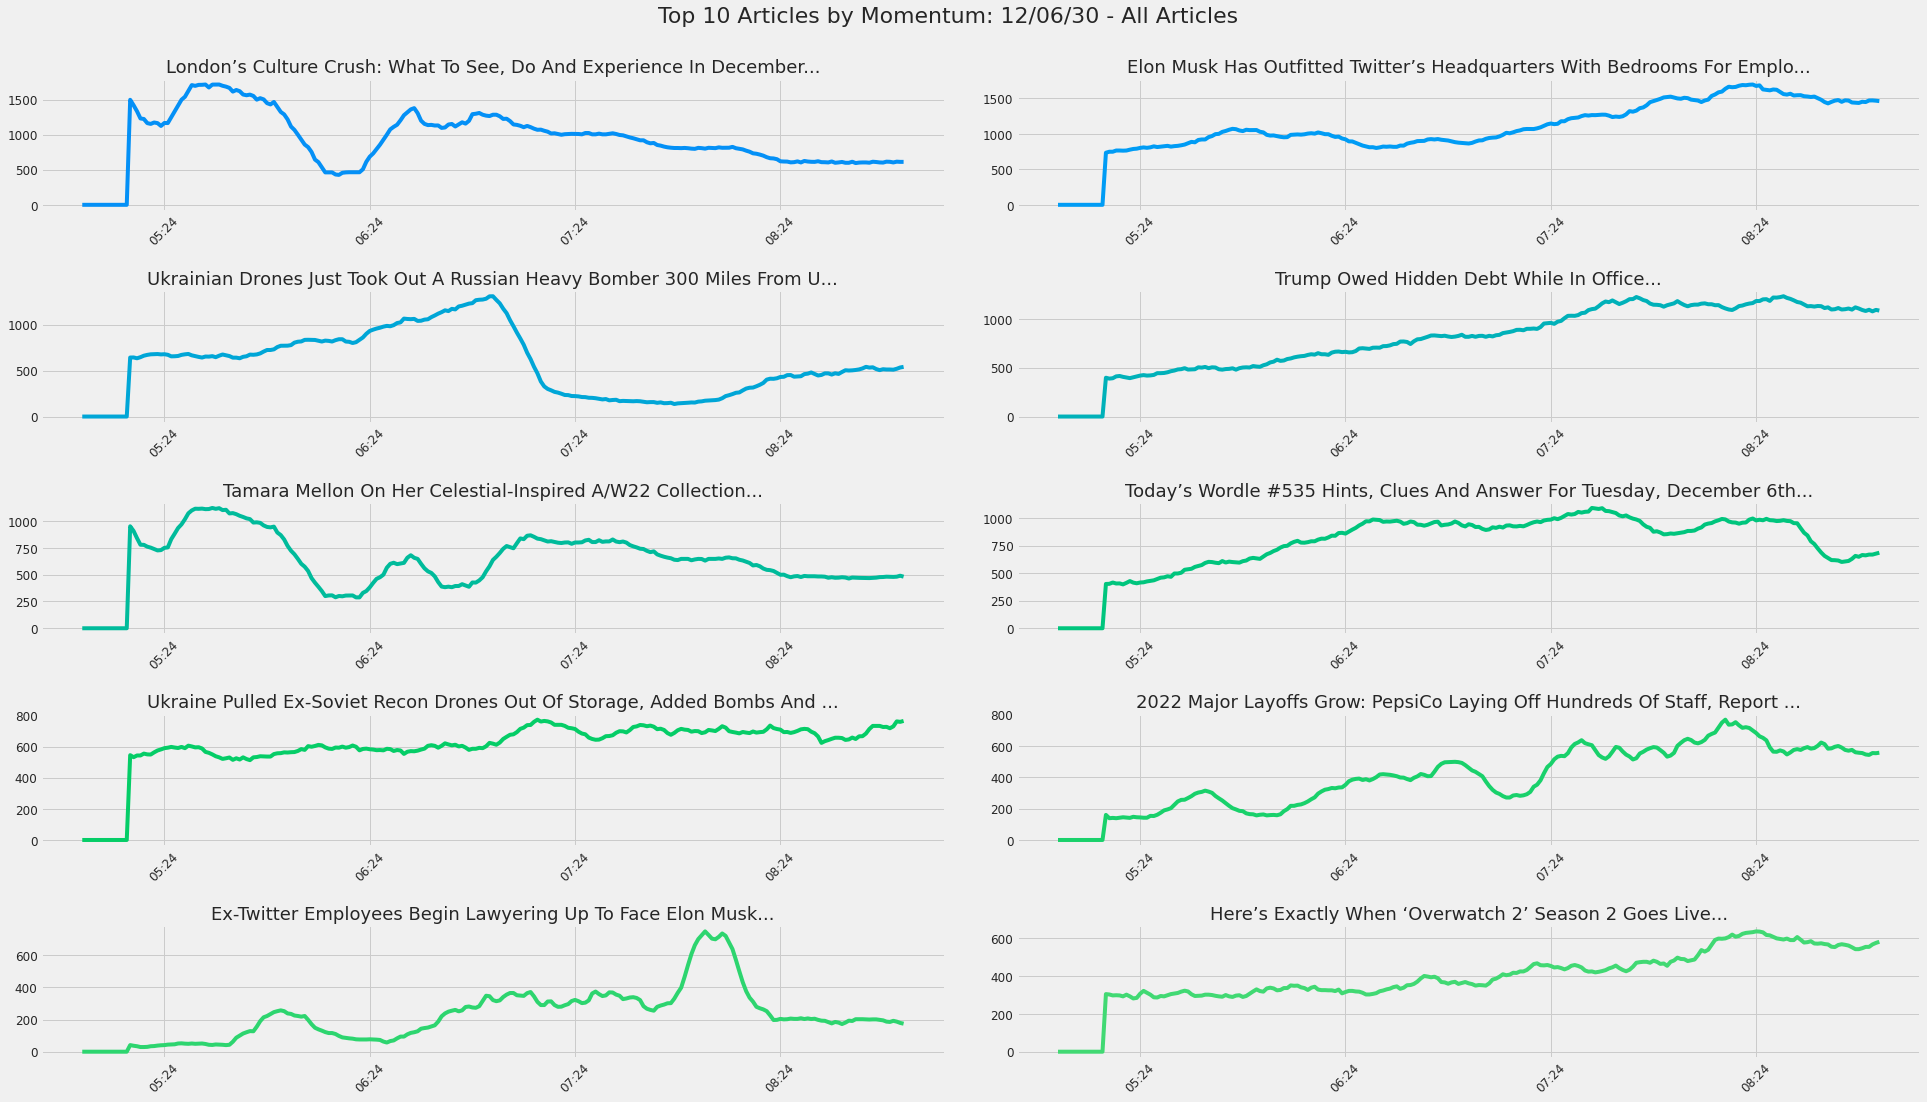

In [39]:
ten_charts(
    df=out,
    fn='top_5am-9am_06Dec_all_articles',
    title='Top 10 Articles by Momentum: 12/06/30 - All Articles'
)

### Bottom




In [40]:
stat.tail(10)

,natid,count,mean,std,min,25%,50%,75%,max,skew,kurt,sharpe_ratio,cv
2,blogandpostid/blog/post/1174-638ca7b6c8f680000...,241.0,47.829876,14.162748,0.0,44.0,50.0,56.0,69.0,-2.062053,5.070607,0.065793,3.377161
0,blogandpostid/blog/post/1114-6384385ce92904000...,241.0,46.526971,14.175988,0.0,43.0,48.0,55.0,69.0,-1.902084,4.288510,0.065540,3.282097
15,blogandpostid/blog/post/3585-636bd6fafe6b1a000...,241.0,37.261411,14.965868,0.0,28.0,38.0,46.0,69.0,-0.381733,0.509978,0.063921,2.489759
49,blogandpostid/blog/post/5660-638c9560c8f680000...,241.0,42.991701,13.552365,0.0,37.0,44.0,53.0,65.0,-1.633877,3.429177,0.066635,3.172266
36,blogandpostid/blog/post/50725-638c13798548bc00...,241.0,39.796680,15.426578,0.0,29.0,45.0,51.0,65.0,-0.828530,0.329199,0.066465,2.579748
16,blogandpostid/blog/post/3585-6388b47d02f92e000...,241.0,36.755187,14.378884,0.0,28.0,38.0,47.0,64.0,-0.648493,0.469667,0.064957,2.556192
13,blogandpostid/blog/post/3585-63595bef33fd14000...,241.0,33.477178,14.422801,0.0,24.0,33.0,45.0,63.0,-0.348349,-0.178282,0.064898,2.321129
48,blogandpostid/blog/post/5388-689,241.0,38.340249,12.221583,0.0,33.0,40.0,46.0,62.0,-1.544196,3.296332,0.067076,3.137094
14,blogandpostid/blog/post/3585-636bd6f9d6ad49000...,241.0,34.481328,13.437225,0.0,27.0,34.0,42.0,62.0,-0.378771,0.873495,0.064259,2.566105
3,blogandpostid/blog/post/1174-638cbe80561a24000...,241.0,35.323651,11.450756,0.0,31.0,37.0,42.0,61.0,-1.378609,3.107999,0.066139,3.084831


In [41]:
bottom_natids=stat['natid'][-n:].tolist()
print(len(bottom_natids))
worst_perf=data[data['natid'].isin (bottom_natids)]
worst_perf.shape

10


(2410, 13)

In [42]:
#Creating Momentum Indicators
bottom=momentum(worst_perf,bottom_natids)
bottom.head()

,natid,title,pub_date,pub_time,pub_date_time,pageviews,hour,minute,ga_date,time,day_time,rolling_pv,return_rolling_pv,sma,upper_bb,rsi
0,blogandpostid/blog/post/1174-638ca7b6c8f680000...,The Best ‘Marvel Snap’ Destroy Deck For Climbi...,2022-12-04,09:02:28,2022-12-04 09:02:28,1.0,5.0,0.0,2022-12-06,05:00:00,2022-12-06 05:00:00,0.0,0.0,0.0,0.0,0.0
1,blogandpostid/blog/post/1174-638ca7b6c8f680000...,The Best ‘Marvel Snap’ Destroy Deck For Climbi...,2022-12-04,09:02:28,2022-12-04 09:02:28,3.0,5.0,1.0,2022-12-06,05:01:00,2022-12-06 05:01:00,0.0,0.0,0.0,0.0,0.0
2,blogandpostid/blog/post/1174-638ca7b6c8f680000...,The Best ‘Marvel Snap’ Destroy Deck For Climbi...,2022-12-04,09:02:28,2022-12-04 09:02:28,1.0,5.0,2.0,2022-12-06,05:02:00,2022-12-06 05:02:00,0.0,0.0,0.0,0.0,0.0
3,blogandpostid/blog/post/1174-638ca7b6c8f680000...,The Best ‘Marvel Snap’ Destroy Deck For Climbi...,2022-12-04,09:02:28,2022-12-04 09:02:28,5.0,5.0,3.0,2022-12-06,05:03:00,2022-12-06 05:03:00,0.0,0.0,0.0,0.0,0.0
4,blogandpostid/blog/post/1174-638ca7b6c8f680000...,The Best ‘Marvel Snap’ Destroy Deck For Climbi...,2022-12-04,09:02:28,2022-12-04 09:02:28,1.0,5.0,4.0,2022-12-06,05:04:00,2022-12-06 05:04:00,0.0,0.0,0.0,0.0,0.0


In [43]:
#final output
out_bottom=bottom[['natid','title','day_time','pageviews','rolling_pv','rsi']]
out_bottom['title'] = out_bottom.groupby(['natid'])['title'].bfill()
out_bottom['title'] = out_bottom.groupby(['natid'])['title'].ffill()
out_bottom.head()

,natid,title,day_time,pageviews,rolling_pv,rsi
0,blogandpostid/blog/post/1174-638ca7b6c8f680000...,The Best ‘Marvel Snap’ Destroy Deck For Climbi...,2022-12-06 05:00:00,1.0,0.0,0.0
1,blogandpostid/blog/post/1174-638ca7b6c8f680000...,The Best ‘Marvel Snap’ Destroy Deck For Climbi...,2022-12-06 05:01:00,3.0,0.0,0.0
2,blogandpostid/blog/post/1174-638ca7b6c8f680000...,The Best ‘Marvel Snap’ Destroy Deck For Climbi...,2022-12-06 05:02:00,1.0,0.0,0.0
3,blogandpostid/blog/post/1174-638ca7b6c8f680000...,The Best ‘Marvel Snap’ Destroy Deck For Climbi...,2022-12-06 05:03:00,5.0,0.0,0.0
4,blogandpostid/blog/post/1174-638ca7b6c8f680000...,The Best ‘Marvel Snap’ Destroy Deck For Climbi...,2022-12-06 05:04:00,1.0,0.0,0.0


In [44]:
out_bottom.title.unique().tolist()

['The Best ‘Marvel Snap’ Destroy Deck For Climbing The Ladder',
 'Russia’s Economic Prospects Have Gone From Bad To Terrible',
 'Smart Cities And 5G: Taking It to the Next Level',
 '‘The Next Generation’—BlackRock CEO Reveals $8 Trillion Fund’s Huge Crypto Prediction After Bitcoin And Ethereum Price Crash',
 'Sarah Jessica Parker Opens Up About Business, Family And ‘The Perfect Cosmo’ This Holiday Season',
 'Betting On Technology: How Governments Can Achieve Climate Equity',
 'How Businesses Can And Must Move Forward In A World Of Scarcity',
 '15 Powerful Quotes On Success',
 'Building A Strong and Sustainable Foundation: Infrastructure and Smart Cities',
 '‘Wednesday’ Season 1 Review: Jenna Ortega Hard Carries Netflix’s New Megahit']

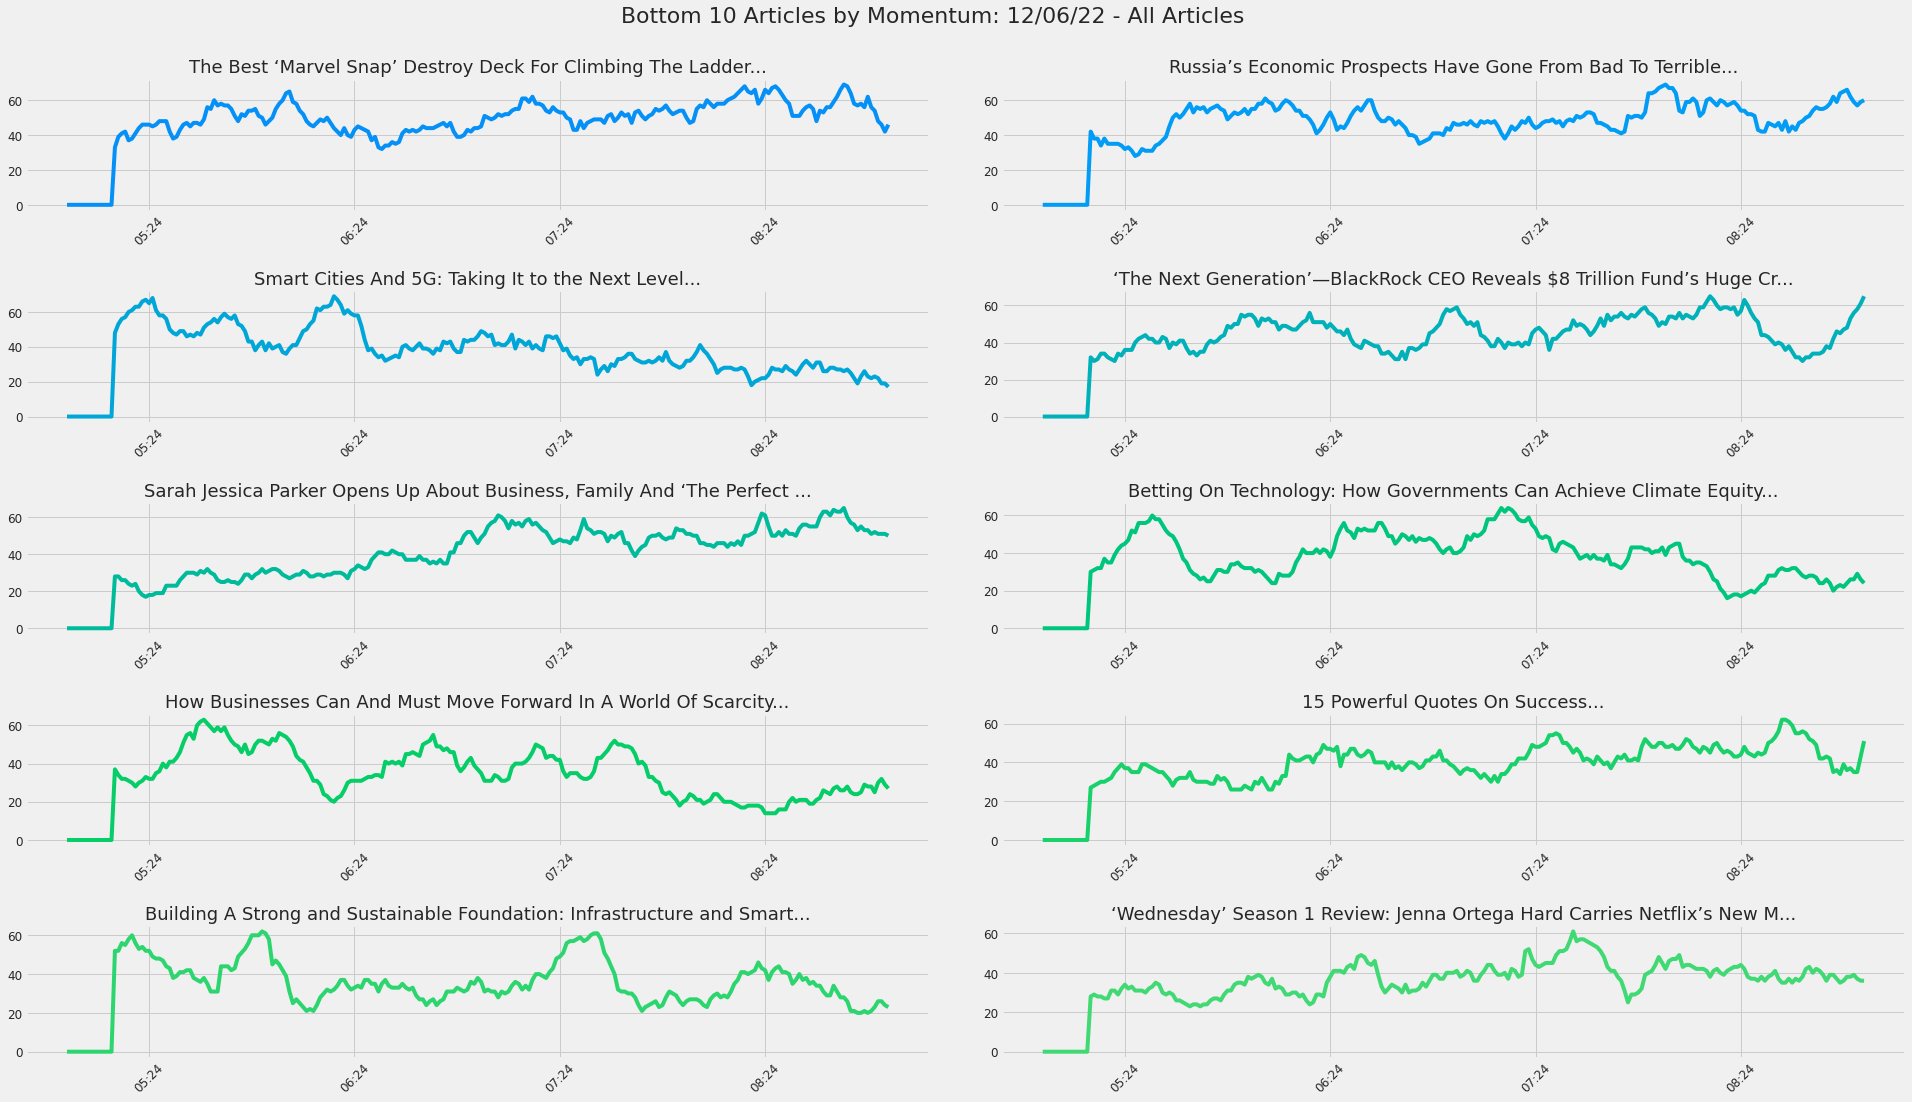

In [45]:
ten_charts(
    df=out_bottom,
    fn='Bottom_5am-9am_06Dec_all_articles',
    title='Bottom 10 Articles by Momentum: 12/06/22 - All Articles'
)